In [2]:
import nplab.datafile as df
import os
import numpy as np
import sklearn.preprocessing as skpre
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import datetime
import h5py
import scipy.signal as sig
from scipy.stats import skew
from scipy.stats import iqr
import matplotlib.cm as cm
import Alexsdatafuncs
datman = Alexsdatafuncs.data_manipulators()
from pandas import DataFrame
import peakutils
import scipy.constants as const
from lmfit.models import GaussianModel
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split 
from matplotlib.ticker import FormatStrFormatter
import pandas as pd
from matplotlib.collections import LineCollection

In [3]:
reload(Alexsdatafuncs)
datman = Alexsdatafuncs.data_manipulators()
alexplot = Alexsdatafuncs.plotting_funcs()

In [4]:
#Colour schemes to use
colours = cm.viridis(np.linspace(0,1,100)) 
colours_2 = cm.hot(np.linspace(0,1,100))

In [5]:
if 'hf' in globals():
    hf.close
    print "File closed"
elif 'data_f' in globals():
    data_f.close
else:
    print "No hdf5 file open"
    pass

No hdf5 file open


In [7]:
#There are two ways to open the file but both use h5py. If nplab.datafile is used the data is sorted automatically by
# timestamp, whereas h5py defaults to sort alphabetically

if 'hf' in globals():
    hf.close
    print "File closed"
else:
    pass

os.chdir('C:/Users/alexc/OneDrive - University of Cambridge/Documents/PhD Project/Projects')
data_f = df.open_file(set_current_bool=False, mode = 'r')

if data_f != None:
    data_f.show_gui()
    filoc = data_f.filename
    data_f.close()
else:
    pass

Cancelled by the user.


In [7]:
# create or open an HDF5 file and open in read mode
if 'filoc' not in globals():
    hf = h5py.File('C:\\Users\\alexc\\OneDrive - University of Cambridge\\Documents\\PhD Project\\Projects\\Boron Nitride spacer\\Trilayer hBN\\2019-03-08_051118_tri2_80nmNPs_2.h5', 'r')
    #hf = h5py.File('C:\\Users\\alexc\\OneDrive - University of Cambridge\\Documents\\PhD Project\\Projects\\Boron Nitride spacer\\Trilayer hBN\\2019-03-07_051118_tri2_80nmNPs.h5', 'r')
else:
    hf = h5py.File(filoc, 'r')
# open dark field data as an list hdf5 object
dfdata = hf.get('OceanOpticsSpectrometer')
# open image data as a list hdf5 object
imdata = hf.get('LumeneraCamera')

In [8]:
# set background, wavelength, reference and timestamp
dat0 = dfdata.get(dfdata.keys()[0])
numspec = len(dfdata.keys())
numpnts = len(dat0)
bgd = dat0.attrs['background']
wls = dat0.attrs['wavelengths']
ts = dat0.attrs['creation_timestamp']

In [9]:
# initialise matrix for dark field, timestamp and combined
dfmat = []
tsmat = []
dfmatwts = []

In [10]:
# Append into matrices the data with it properly referenced
i = 0
for i in range(0, numspec):
    temp = dfdata.get(dfdata.keys()[i])
    temparr = np.array(temp)
    dfield = (temparr - bgd) / (temp.attrs['reference'] - bgd)
    dfmat.append(dfield)
    ts = datetime.datetime.strptime(temp.attrs['creation_timestamp'][:19],
                                    "%Y-%m-%dT%H:%M:%S")
    dfwts = np.append(dfield, ts)  # append the timestamp to the end of the dataset
    dfmatwts.append(dfwts)


In [11]:
# If the data isn't already sorted by timestamp then this will sort it in this way
# sort by the end timestamp value and then delete the timestamp column

dfmatwts.sort(key=lambda row: row[-1:])

In [12]:
# Paste the threshold time from the gui into variable tsthreshold and this will split into two seperate datasets

#tsthreshold = datetime.datetime.strptime("2019-03-07T15:29:24.119000", "%Y-%m-%dT%H:%M:%S.%f")
tsthreshold = datetime.datetime.strptime("2019-03-08T15:42:26.447000", "%Y-%m-%dT%H:%M:%S.%f")
dfoff = []
dfon = []
i=0
for i in range(0, len(dfmatwts)):
    if dfmatwts[i][-1] > tsthreshold:
        dfoff.append(dfmatwts[i])
    elif dfmatwts[i][-1] <= tsthreshold:
        dfon.append(dfmatwts[i])
    else:
        pass

dfoffsorted = np.delete(dfoff, -1, axis=1)
dfonsorted = np.delete(dfon, -1, axis=1)


In [13]:
len(dfoffsorted)

184

In [14]:
len(dfonsorted)

256

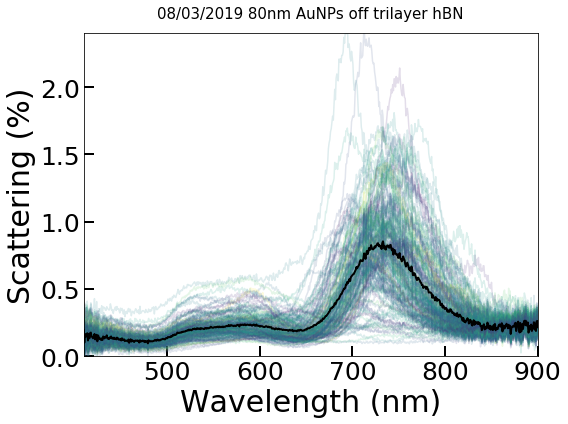

In [13]:
fig, ax, avdf_off = alexplot.plot_all_df(spectra=dfoffsorted, wls=wls, colours=colours)
ax.set_title('08/03/2019 80nm AuNPs off trilayer hBN', fontsize=15, pad=15)
ax.set_ylim(0,2.4)

plt.tight_layout()
fig.savefig('C:\\Users\\alexc\\OneDrive - University of Cambridge\\Documents\\PhD Project\\Projects\\Boron Nitride spacer\\Trilayer hBN\\2019-03-07_051118_tri2_80nmNPs data analysis\\08_03_2019 80nm AuNPs on trilayer hBN_all data.jpg', layout='tight')

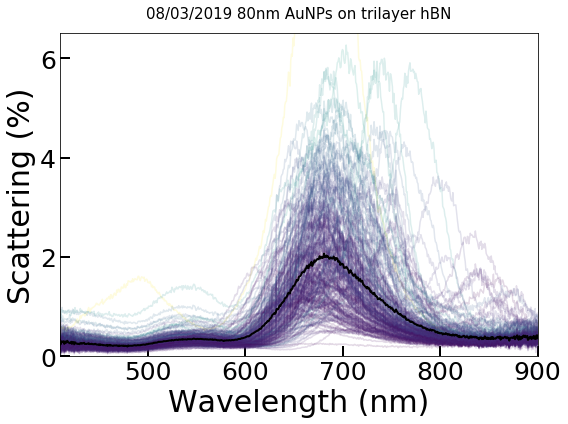

In [14]:
#plot all dark field spectra for on hBN
fig, ax, avdf_on = alexplot.plot_all_df(spectra=dfonsorted, wls=wls, colours=colours)
ax.set_title('08/03/2019 80nm AuNPs on trilayer hBN', fontsize=15, pad=15)
ax.set_ylim(0,6.5)
plt.tight_layout()
fig.savefig('C:\\Users\\alexc\\OneDrive - University of Cambridge\\Documents\\PhD Project\\Projects\\Boron Nitride spacer\\Trilayer hBN\\2019-03-07_051118_tri2_80nmNPs data analysis\\08_03_2019 80nm AuNPs off trilayer hBN_all data.jpg')

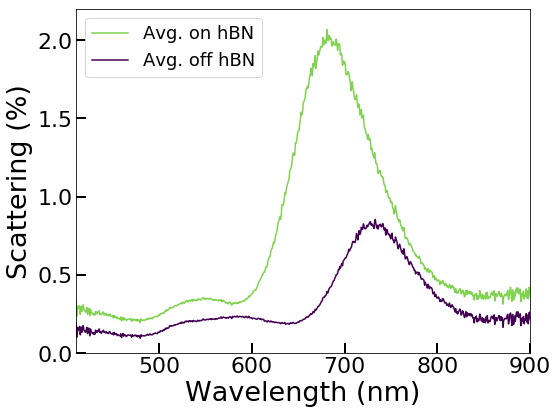

In [16]:
# Plot of average on and off on the same graph

fig = plt.figure(1, figsize=(8,6))
ax = fig.add_subplot(111)
ax.plot(wls, avdf_on*100, color=colours[80], label="Avg. on hBN")
ax.plot(wls, avdf_off*100, color=colours[0], label="Avg. off hBN")
ax.set_xlim(410,900)
ax.set_ylim(0,2.2)
ax.legend(fontsize=18)
ax.tick_params(labelsize=22, direction='in', length=10, width=2)
ax.set_xlabel("Wavelength (nm)", fontsize=27)
ax.set_ylabel("Scattering (%)", fontsize=27)
plt.tight_layout(pad=1.6)
fig.savefig('C:\\Users\\alexc\\OneDrive - University of Cambridge\\Documents\\PhD Project\\Projects\\Boron Nitride spacer\\Trilayer hBN\\2019-03-07_051118_tri2_80nmNPs data analysis\\08_03_2019 80nm AuNPs average on_off trilayer hBN all data.jpg')

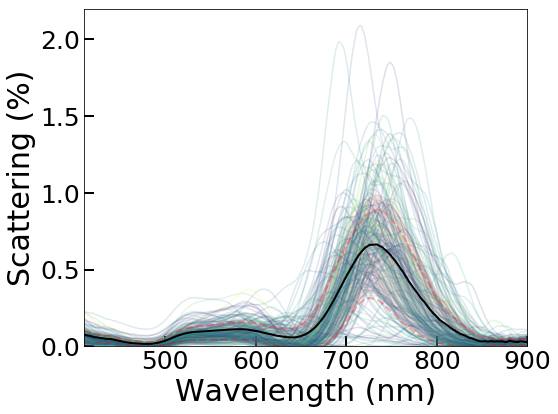

In [15]:
fig, ax, dfoff_filt,avdf_off_filt, wls_cr, std_off_filt = alexplot.plot_all_smooth_df(spectra=dfoffsorted, wls=wls, colours=colours, baseline_subtract=1,order=1)
ax.set_ylim(0,2.2)
plt.tight_layout(pad=1.6)
fig.savefig('C:\\Users\\alexc\\OneDrive - University of Cambridge\\Documents\\PhD Project\\Projects\\Boron Nitride spacer\\Trilayer hBN\\2019-03-07_051118_tri2_80nmNPs data analysis\\08_03_2019 80nm AuNPs average off trilayer hBN all data smoothed.jpg')

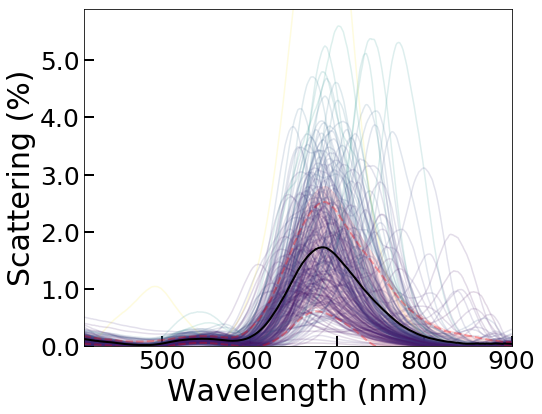

In [17]:
fig, ax, dfon_filt,avdf_on_filt, wls_cr, std_on_filt = alexplot.plot_all_smooth_df(spectra=dfonsorted, wls=wls, colours=colours, baseline_subtract=1, order=1)
ax.set_ylim(0,5.9)
fig.savefig('C:\\Users\\alexc\\OneDrive - University of Cambridge\\Documents\\PhD Project\\Projects\\Boron Nitride spacer\\Trilayer hBN\\2019-03-07_051118_tri2_80nmNPs data analysis\\08_03_2019 80nm AuNPs average on trilayer hBN all data smoothed.jpg')

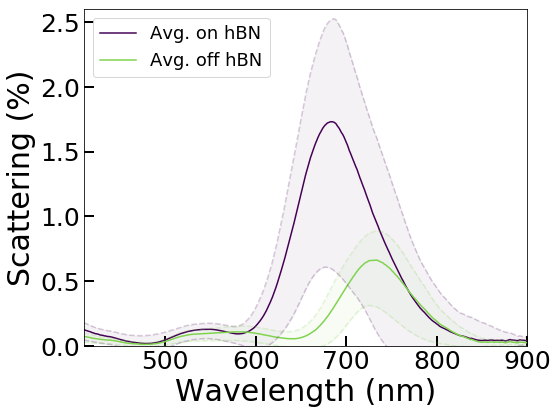

In [18]:
fig = plt.figure(1, figsize=(8,6))
ax = fig.add_subplot(111)
ax.plot(wls_cr, avdf_on_filt*100, color=colours[0], label="Avg. on hBN")
avplusdev_on = (avdf_on_filt + std_on_filt)*0.9
avmindev_on = (avdf_on_filt - std_on_filt)*0.9
avplusdev_off = (avdf_off_filt + std_off_filt)*0.9
avmindev_off = (avdf_off_filt - std_off_filt)*0.9
ax.plot(wls_cr, avdf_off_filt*100, color=colours[80], label="Avg. off hBN")
ax.plot(wls_cr, avplusdev_on*100, wls_cr, avmindev_on*100, linestyle='--', color=colours[0], alpha=0.2)
ax.plot(wls_cr, avplusdev_off*100, wls_cr, avmindev_off*100, linestyle='--', color=colours[80], alpha=0.2)
ax.fill_between(wls_cr, avmindev_on*100, avplusdev_on*100, alpha=0.05, color=colours[0])
ax.fill_between(wls_cr, avmindev_off*100, avplusdev_off*100, alpha=0.05, color=colours[80])
ax.set_xlim(410,900)
ax.set_ylim(0,2.6)
ax.legend(fontsize=18)
ax.tick_params(labelsize=25, direction='in', length=10, width=2)
ax.set_xlabel("Wavelength (nm)", fontsize=30)
ax.set_ylabel("Scattering (%)", fontsize=30)
plt.tight_layout(pad=1.6)
fig.savefig('C:\\Users\\alexc\\OneDrive - University of Cambridge\\Documents\\PhD Project\\Projects\\Boron Nitride spacer\\Trilayer hBN\\2019-03-07_051118_tri2_80nmNPs data analysis\\08_03_2019 80nm AuNPs average on_off trilayer hBN all data smoothed.jpg')

spectra same length


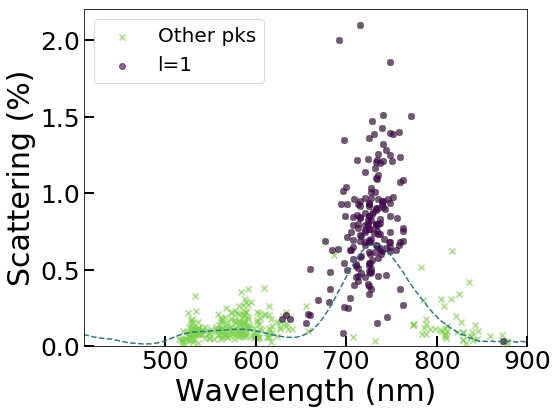

In [19]:
fig, ax, dfoff_pk_wls, dfoff_pk_ints, dfoff_pkwls_vec, dfoff_pkints_vec,\
l1_only_ints_off, l1_only_wls_off = alexplot.plot_all_peaks(spectra=dfoff_filt, wls=wls_cr, colours=colours, threshold=0.02, start_wl=500, end_wl=880)
arg_zero = np.argwhere(l1_only_wls_off == np.min(l1_only_wls_off))[0][0]
l1_only_ints_off = np.delete(l1_only_ints_off, arg_zero)
l1_only_wls_off = np.delete(l1_only_wls_off, arg_zero)
ax.legend(fontsize=20)
fig.savefig('C:\\Users\\alexc\\OneDrive - University of Cambridge\\Documents\\PhD Project\\Projects\\Boron Nitride spacer\\Trilayer hBN\\2019-03-07_051118_tri2_80nmNPs data analysis\\08_03_2019 80nm AuNPs off trilayer hBN peaks and average.jpg')

In [20]:
sorted_df_off = datman.sort_coupled_modes(dfoff_filt, dfoff_pk_ints, dfoff_pk_wls)

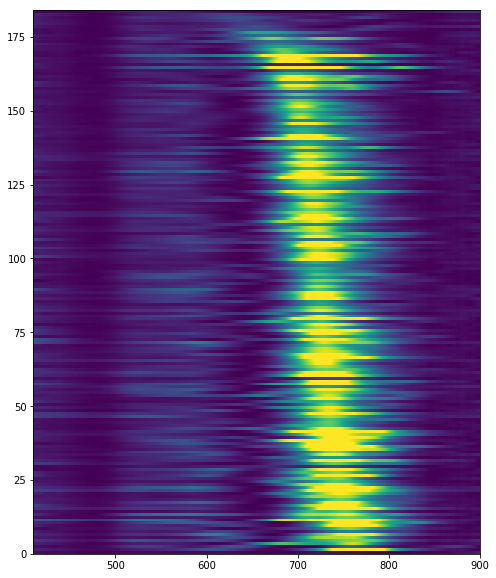

In [21]:
fig = plt.figure(1,figsize=(8,10))
ax = fig.add_subplot(111)
ax.imshow((sorted_df_off*100), extent=[wls_cr[0], wls_cr[-1], 0, len(sorted_df_off)], 
          aspect='auto', vmin=0, vmax=np.max(sorted_df_off*100)*0.4)


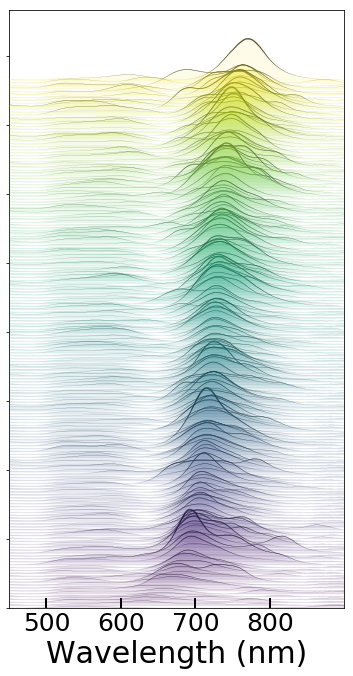

In [22]:
fig, ax, sorted_offset_off = alexplot.offset_map(spectra=sorted_df_off, wls=wls_cr, lthickness=80, offset_fact=0.05)
ax.set_xticks(np.arange(500,900, 100))
fig.savefig('C:\\Users\\alexc\\OneDrive - University of Cambridge\\Documents\\PhD Project\\Projects\\Boron Nitride spacer\\Trilayer hBN\\2019-03-07_051118_tri2_80nmNPs data analysis\\08_03_2019 80nm AuNPs off trilayer hBN peaks and average.jpg')

spectra same length


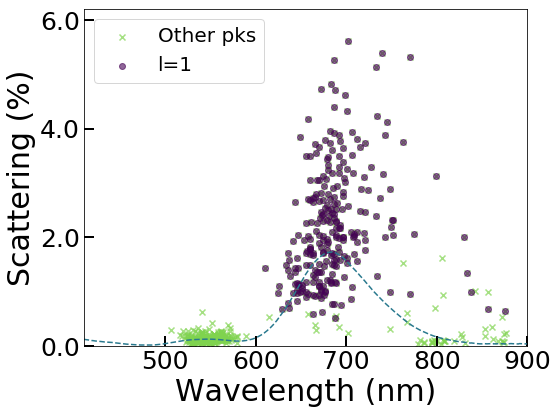

In [23]:
fig, ax, dfon_pk_wls, dfon_pk_ints, dfon_pkwls_vec, dfon_pkints_vec,\
l1_only_ints_on, l1_only_wls_on = alexplot.plot_all_peaks(spectra=dfon_filt, wls=wls_cr, colours=colours, threshold=0.02, start_wl=500, end_wl=880)
arg_zero = np.argwhere(l1_only_wls_on == np.min(l1_only_wls_on))[0][0]
l1_only_ints_on = np.delete(l1_only_ints_on, arg_zero)
l1_only_wls_on = np.delete(l1_only_wls_on, arg_zero)
ax.set_ylim(0,6.2)
ax.legend(fontsize=20)
fig.savefig('C:\\Users\\alexc\\OneDrive - University of Cambridge\\Documents\\PhD Project\\Projects\\Boron Nitride spacer\\Trilayer hBN\\2019-03-07_051118_tri2_80nmNPs data analysis\\08_03_2019 80nm AuNPs on trilayer hBN peaks and average.jpg')

In [24]:
sorted_df_on = datman.sort_coupled_modes(dfon_filt, dfon_pk_ints, dfon_pk_wls)

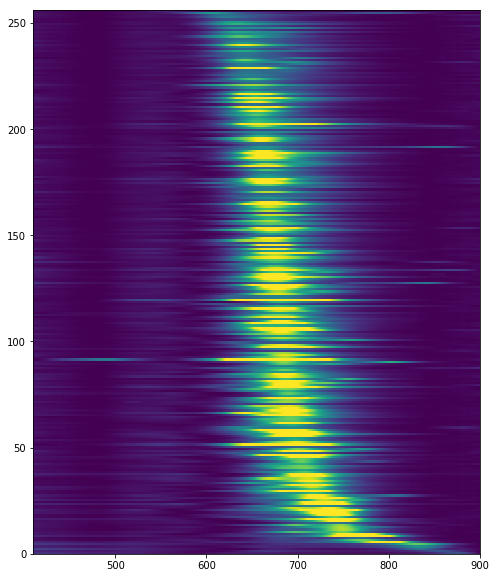

In [25]:
fig = plt.figure(1,figsize=(8,10))
ax = fig.add_subplot(111)
ax.imshow((sorted_df_on*100), extent=[wls_cr[0], wls_cr[-1], 0, len(sorted_df_on)], 
          aspect='auto', vmin=0, vmax=np.max(sorted_df_on*100)*0.3)

In [26]:
outlier_spec = np.argwhere(sorted_df_on == np.max(sorted_df_on))[0][0]
sorted_df_on = np.delete(sorted_df_on, outlier_spec, axis=0)

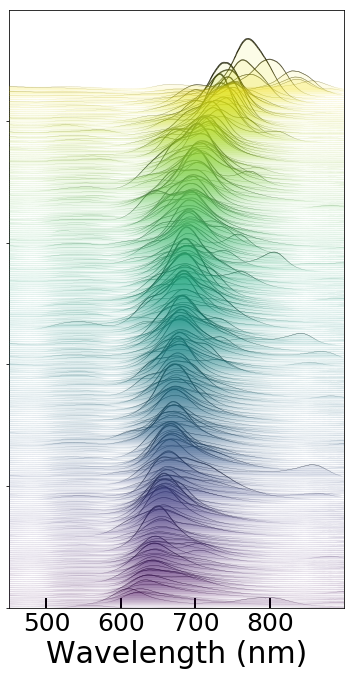

In [27]:
fig, ax, sorted_offset_on = alexplot.offset_map(spectra=sorted_df_on, wls=wls_cr, offset_fact=0.03, lthickness=30)
ax.set_xticks(np.arange(500,900, 100))
fig.savefig('C:\\Users\\alexc\\OneDrive - University of Cambridge\\Documents\\PhD Project\\Projects\\Boron Nitride spacer\\Trilayer hBN\\2019-03-07_051118_tri2_80nmNPs data analysis\\08_03_2019 80nm AuNPs on trilayer hBN offset map.jpg')

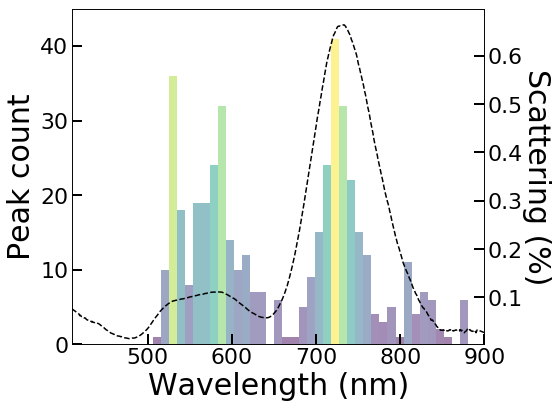

In [28]:
# Count number of histogram peaks above a certain threshold and use for kmeans
fig, ax, ax2, n_off, bins_off = alexplot.peak_histogram(allpkwls=dfoff_pkwls_vec, wls=wls_cr, colours=colours, av_spectrum=avdf_off_filt)
ax.set_xlim(410,900)
ax.set_ylim(0, 45)
ax2.set_ylim(0.003,)
fig.savefig('C:\\Users\\alexc\\OneDrive - University of Cambridge\\Documents\\PhD Project\\Projects\\Boron Nitride spacer\\Trilayer hBN\\2019-03-07_051118_tri2_80nmNPs data analysis\\08_03_2019 80nm AuNPs off trilayer hBN histogram and average.jpg')

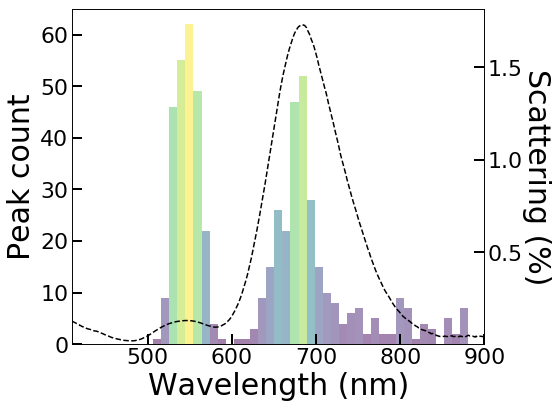

In [29]:
fig, ax, ax2,  n_on, bins_on = alexplot.peak_histogram(allpkwls=dfon_pkwls_vec, wls=wls_cr, colours=colours, av_spectrum=avdf_on_filt)
ax.set_xlim(410,900)
ax.set_ylim(0, 65)
ax2.set_ylim(0.003,)
fig.savefig('C:\\Users\\alexc\\OneDrive - University of Cambridge\\Documents\\PhD Project\\Projects\\Boron Nitride spacer\\Trilayer hBN\\2019-03-07_051118_tri2_80nmNPs data analysis\\08_03_2019 80nm AuNPs on trilayer hBN histogram and average.jpg')

array([[7.27159871e+02, 7.85900876e-03],
       [5.99897450e+02, 1.52485166e-03],
       [5.42122972e+02, 9.80485788e-04],
       [8.23661565e+02, 1.37590027e-03]])

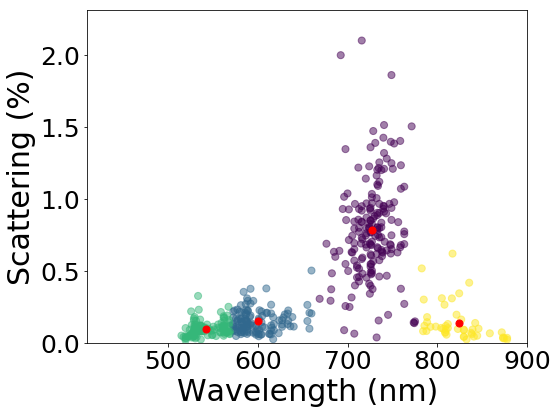

In [30]:
#Use kmeans to find peak centres
fig, ax, dframe, kmeans_off, centroids_off, labels = alexplot.kmeans_pkplot(dfoff_pkwls_vec, dfoff_pkints_vec, n_clusters=4)
ax.set_ylim(0, max(dframe['y'] * 110))
ax.set_xlim(410, 900)
ax.set_xlabel("Wavelength (nm)", fontsize=30)
ax.set_ylabel("Scattering (%)", fontsize=30)
ax.tick_params(labelsize=25)
fig.tight_layout(pad=1.6)
columns_off = ['0', '1', '2', '3']
dframe_off = pd.DataFrame(columns=columns_off)
i=0


for i in range(0, len(labels)):
    if labels[i] == 0:
        dframe_off = dframe_off.append({'0': dfoff_pkwls_vec[i]}, ignore_index=True)
    if labels[i] == 1:
        dframe_off = dframe_off.append({'1': dfoff_pkwls_vec[i]}, ignore_index=True)
    if labels[i] == 2:
        dframe_off = dframe_off.append({'2': dfoff_pkwls_vec[i]}, ignore_index=True)
    if labels[i] == 3:
        dframe_off = dframe_off.append({'3': dfoff_pkwls_vec[i]}, ignore_index=True)
        

fig.savefig('C:\\Users\\alexc\\OneDrive - University of Cambridge\\Documents\\PhD Project\\Projects\\Boron Nitride spacer\\Trilayer hBN\\2019-03-07_051118_tri2_80nmNPs data analysis\\08_03_2019 80nm AuNPs on trilayer hBN Kmeans.jpg')
centroids_off

In [31]:
centroid_num = 1
l1_mode_pkwl_off = []
l1_mode_pkint_off = []
colours_2 = []
for i in range(0, len(dframe_off[str(centroid_num)])):
    if np.isnan(dframe_off[str(centroid_num)][i]) == False:
        l1_mode_pkwl_off.append(dframe_off[str(centroid_num)][i])
        l1_mode_pkint_off.append(dfoff_pkwls_vec[i])
        colours_2.append(kmeans_off.labels_.astype(float)[i])
    else:
        pass

In [32]:
argmaxint = np.argmax(l1_only_wls_off)
l1_only_wls_off = np.delete(l1_only_wls_off,argmaxint)
l1_only_ints_off = np.delete(l1_only_ints_off,argmaxint)

-1.2116330755819829

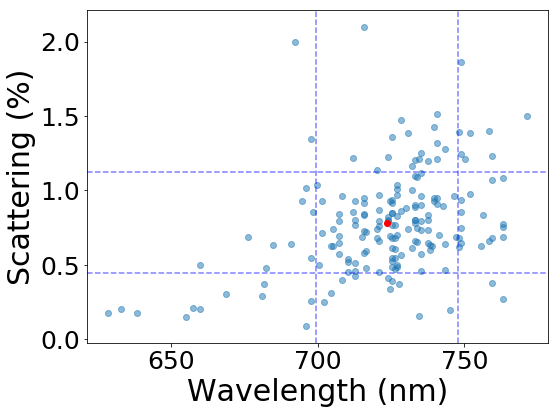

In [33]:
fig = plt.figure(1, figsize=(8,6))
ax = fig.add_subplot(111)
ax.scatter(l1_only_wls_off, l1_only_ints_off*100, alpha=0.5)
mean_dipole_off = np.mean(l1_only_wls_off)
mean_dipole_off_int = np.mean(l1_only_ints_off*100)
ax.scatter(mean_dipole_off, mean_dipole_off_int, color='r')
std_dipole_off = np.std(l1_only_wls_off)
std_dipole_off_int = np.std(l1_only_ints_off*100)
ax.axvline(mean_dipole_off+std_dipole_off, linestyle='--', color='blue',alpha=0.5)
ax.axvline(mean_dipole_off-std_dipole_off, linestyle='--', color='blue', alpha=0.5)
ax.axhline(mean_dipole_off_int+std_dipole_off_int, linestyle='--', color='blue', alpha=0.5)
ax.axhline(mean_dipole_off_int-std_dipole_off_int, linestyle='--', color='blue', alpha=0.5)
ax.set_ylabel("Scattering (%)", fontsize=30)
ax.set_xlabel("Wavelength (nm)", fontsize=30)
ax.tick_params(labelsize=25)

ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
plt.tight_layout(pad=1.6)
fig.savefig('C:\\Users\\alexc\\OneDrive - University of Cambridge\\Documents\\PhD Project\\Projects\\Boron Nitride spacer\\Trilayer hBN\\2019-03-07_051118_tri2_80nmNPs data analysis\\80nm NPs off tri hBN l1 dist.jpg')
skew(l1_only_wls_off)

In [34]:
skew(l1_only_ints_off)

0.7558759847259656

In [35]:
iqr(l1_only_wls_off)

24.832058167074138

array([[5.48651004e+02, 1.61832227e-03],
       [7.04628320e+02, 1.94838607e-02]])

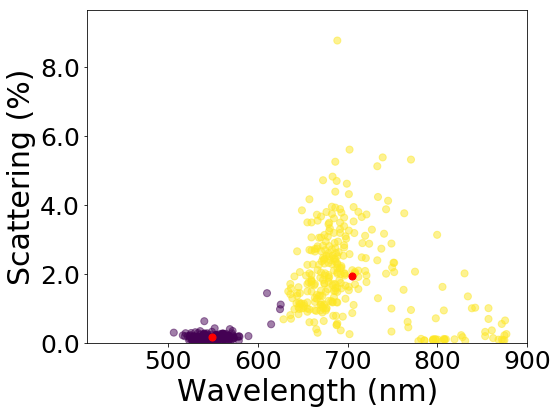

In [36]:
#Use kmeans to find peak centres
fig, ax, dframe, kmeans_on, centroids_on, labels = alexplot.kmeans_pkplot(dfon_pkwls_vec, dfon_pkints_vec, n_clusters=2)
ax.set_ylim(0, max(dframe['y'] * 110))
ax.set_xlim(410, 900)
ax.set_xlabel("Wavelength (nm)", fontsize=30)
ax.set_ylabel("Scattering (%)", fontsize=30)
ax.tick_params(axis='x', labelsize=25), ax.tick_params(axis='y', labelsize=25)
fig.tight_layout(pad=1.6)
columns_on = ['0', '1', '2']
dframe_on = pd.DataFrame(columns=columns_on)
i=0;j=0
#for i in range(0, len(labels)):
#    for j in range(len(columns_on)):
#        if labels[i] == 0:
#            dframe_on = dframe_on.append({str(j): l1_only_wls_on[i]}, ignore_index=True)

for i in range(0, len(labels)):
    if labels[i] == 0:
        dframe_on = dframe_on.append({'0': dfon_pkwls_vec[i]}, ignore_index=True)
    if labels[i] == 1:
        dframe_on = dframe_on.append({'1': dfon_pkwls_vec[i]}, ignore_index=True)
        

fig.savefig('C:\\Users\\alexc\\OneDrive - University of Cambridge\\Documents\\PhD Project\\Projects\\Boron Nitride spacer\\Trilayer hBN\\2019-03-07_051118_tri2_80nmNPs data analysis\\08_03_2019 80nm AuNPs on trilayer hBN Kmeans.jpg')
centroids_on

In [37]:
centroid_num = 1
l1_mode_pkwl_on = []
l1_mode_pkint_on = []
colours_2 = []
for i in range(0, len(dframe_on[str(centroid_num)])):
    if np.isnan(dframe_on[str(centroid_num)][i]) == False:
        l1_mode_pkwl_on.append(dframe_on[str(centroid_num)][i])
        l1_mode_pkint_on.append(l1_only_ints_on[i])
        colours_2.append(kmeans_on.labels_.astype(float)[i])
    else:
        pass

IndexError: index 256 is out of bounds for axis 0 with size 255

In [38]:
argmaxint = np.argmax(l1_only_ints_on)
l1_only_wls_on = np.delete(l1_only_wls_on,argmaxint)
l1_only_ints_on = np.delete(l1_only_ints_on,argmaxint)

1.911646131298472

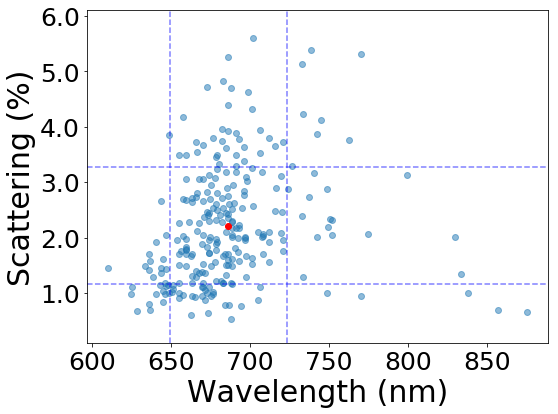

In [39]:
# plotting the peak positions of all peaks with highest intensity for each spectrum

fig = plt.figure(1, figsize=(8,6))
ax = fig.add_subplot(111)
ax.scatter(l1_only_wls_on, l1_only_ints_on*100, alpha=0.5)
mean_dipole_on = np.mean(l1_only_wls_on)
mean_dipole_on_int = np.mean(l1_only_ints_on*100)
ax.scatter(mean_dipole_on, mean_dipole_on_int, color='r')
std_dipole_on = np.std(l1_only_wls_on)
std_dipole_on_int = np.std(l1_only_ints_on*100)
ax.axvline(mean_dipole_on+std_dipole_on, linestyle='--', color='blue',alpha=0.5)
ax.axvline(mean_dipole_on-std_dipole_on, linestyle='--', color='blue', alpha=0.5)
#ax.axvline(mean_dipole_on+std_dipole_on*3, linestyle='--', color='blue', alpha=0.5)
ax.axhline(mean_dipole_on_int+std_dipole_on_int, linestyle='--', color='blue', alpha=0.5)
ax.axhline(mean_dipole_on_int-std_dipole_on_int, linestyle='--', color='blue', alpha=0.5)
ax.set_ylabel("Scattering (%)", fontsize=30)
ax.set_xlabel("Wavelength (nm)", fontsize=30)
ax.tick_params(labelsize=25)
ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
plt.tight_layout(pad=1.6)
ax.set_ylim(0.1, 6.1)
fig.savefig('C:\\Users\\alexc\\OneDrive - University of Cambridge\\Documents\\PhD Project\\Projects\\Boron Nitride spacer\\Trilayer hBN\\2019-03-07_051118_tri2_80nmNPs data analysis\\80nm NPs on tri hBN l1 dist.jpg')
skew(l1_only_wls_on)

In [40]:
skew(l1_only_ints_on)

0.7856941201051267

In [41]:
iqr(l1_only_wls_on)

31.027376659392758

In [42]:
# Iterate through and create matrix containing gaussian fits for each spectrum
fit_mat_off = []
for i in range(0, len(dfoff_filt)):
    print "Fitting spectrum: " + str(i) + " of " + str(len(dfoff_filt))
    fit = datman.gaussian_fit_2(x_data=wls_cr, y_data=dfoff_filt[i], x_peak_indexes=dfoff_pk_wls[i], y_peak_values=dfoff_pk_ints[i])
    fit_mat_off.append(fit)

Fitting spectrum: 0 of 184
Fitting spectrum: 1 of 184
Fitting spectrum: 2 of 184
Fitting spectrum: 3 of 184
Fitting spectrum: 4 of 184
Fitting spectrum: 5 of 184
Fitting spectrum: 6 of 184
Fitting spectrum: 7 of 184
Fitting spectrum: 8 of 184
Fitting spectrum: 9 of 184
Fitting spectrum: 10 of 184
Fitting spectrum: 11 of 184
Fitting spectrum: 12 of 184
Fitting spectrum: 13 of 184
Fitting spectrum: 14 of 184
Fitting spectrum: 15 of 184
Fitting spectrum: 16 of 184
Fitting spectrum: 17 of 184
Fitting spectrum: 18 of 184
Fitting spectrum: 19 of 184
Fitting spectrum: 20 of 184
Fitting spectrum: 21 of 184
Fitting spectrum: 22 of 184
Fitting spectrum: 23 of 184
Fitting spectrum: 24 of 184
Fitting spectrum: 25 of 184
Fitting spectrum: 26 of 184
Fitting spectrum: 27 of 184
Fitting spectrum: 28 of 184
Fitting spectrum: 29 of 184
Fitting spectrum: 30 of 184
Fitting spectrum: 31 of 184
Fitting spectrum: 32 of 184
Fitting spectrum: 33 of 184
Fitting spectrum: 34 of 184
Fitting spectrum: 35 of 184
Fi

In [43]:
# Iterate through and create matrix containing gaussian fits for each spectrum
fit_mat_on = []
for i in range(0, len(dfon_filt)):
    print "Fitting spectrum: " + str(i) + " of " + str(len(dfon_filt))
    fit = datman.gaussian_fit_2(x_data=wls_cr, y_data=dfon_filt[i], x_peak_indexes=dfon_pk_wls[i], y_peak_values=dfon_pk_ints[i])
    fit_mat_on.append(fit)
    

Fitting spectrum: 0 of 256
Fitting spectrum: 1 of 256
Fitting spectrum: 2 of 256
Fitting spectrum: 3 of 256
Fitting spectrum: 4 of 256
Fitting spectrum: 5 of 256
Fitting spectrum: 6 of 256
Fitting spectrum: 7 of 256
Fitting spectrum: 8 of 256
Fitting spectrum: 9 of 256
Fitting spectrum: 10 of 256
Fitting spectrum: 11 of 256
Fitting spectrum: 12 of 256
Fitting spectrum: 13 of 256
Fitting spectrum: 14 of 256
Fitting spectrum: 15 of 256
Fitting spectrum: 16 of 256
Fitting spectrum: 17 of 256
Fitting spectrum: 18 of 256
Fitting spectrum: 19 of 256
Fitting spectrum: 20 of 256
Fitting spectrum: 21 of 256
Fitting spectrum: 22 of 256
Fitting spectrum: 23 of 256
Fitting spectrum: 24 of 256
Fitting spectrum: 25 of 256
Fitting spectrum: 26 of 256
Fitting spectrum: 27 of 256
Fitting spectrum: 28 of 256
Fitting spectrum: 29 of 256
Fitting spectrum: 30 of 256
Fitting spectrum: 31 of 256
Fitting spectrum: 32 of 256
Fitting spectrum: 33 of 256
Fitting spectrum: 34 of 256
Fitting spectrum: 35 of 256
Fi

In [44]:
# Calculate Q factors for each mode and each spectrum
fit_plots_off = []
i=0
for i in range(0, len(fit_mat_off)):
    fit_plots_off.append(fit_mat_off[i].best_fit)
    
q_factors_off, max_ints_off, fwhms_off = datman.q_factor_calc(x_data=wls_cr, y_data=fit_plots_off)

In [45]:
fit_l1_wls_off = np.zeros(len(fit_mat_off))
for i in range(len(fit_mat_off)):
    arg_max = np.argwhere(fit_mat_off[i].best_fit == np.max(fit_mat_off[i].best_fit))[0][0]
    pk_posn = wls_cr[arg_max]
    fit_l1_wls_off[i] = pk_posn

In [46]:
# Calculate Q factors for each mode and each spectrum
fit_plots_on = []
i=0
for i in range(0, len(fit_mat_on)):
    fit_plots_on.append(fit_mat_on[i].best_fit)
    
q_factors_on, max_ints_on, fwhms_on = datman.q_factor_calc(x_data=wls_cr, y_data=fit_plots_on)

In [47]:
fit_l1_wls_on = np.zeros(len(fit_mat_on))
i=0
for i in range(len(fit_mat_on)):
    arg_max = np.argwhere(fit_mat_on[i].best_fit == np.max(fit_mat_on[i].best_fit))[0][0]
    pk_posn = wls_cr[arg_max]
    fit_l1_wls_on[i] = pk_posn
    

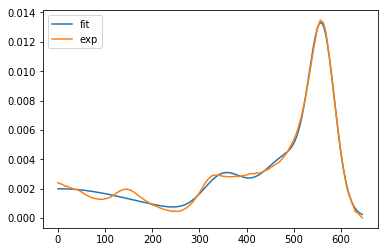

In [48]:
test_n = 240
plt.plot(fit_mat_on[test_n].best_fit, label='fit')
plt.plot(dfon_filt[test_n], label = 'exp')
plt.legend()

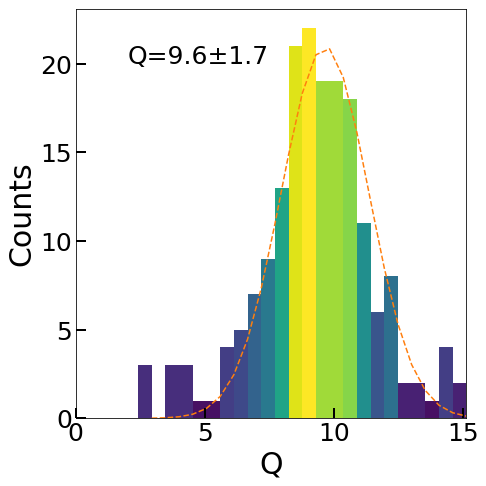

In [49]:
q_factors_off = np.array(q_factors_off)
fig, ax, n_off, bins_off = alexplot.default_hist(q_factors_off, colours=colours)
ax.set_xlabel("Q", fontsize=30)
ax.set_ylabel('Counts', fontsize=30)
ax.tick_params(labelsize=25, direction='in', size=10, width=2)
multi_gauss_a = GaussianModel(prefix='g' + str(0) + '_')
multi_gauss_fit_a = multi_gauss_a.fit(n_off, x=bins_off[1:])
ax.plot(bins_off[1:],multi_gauss_fit_a.best_fit, linestyle='--')
qcentre = np.round(multi_gauss_fit_a.best_values.get('g0_center'),1)
qsigma = np.round(multi_gauss_fit_a.best_values.get('g0_sigma'),1)
ax.text(2, 20,"Q="+str(qcentre)+ u'\u00b1'+str(qsigma), fontsize=25)
multi_gauss_fit_a.best_values
ax.set_xlim(0,)
plt.tight_layout(pad=1.6)
plt.savefig('C:\\Users\\alexc\\OneDrive - University of Cambridge\\Documents\\PhD Project\\Projects\\Boron Nitride spacer\\Trilayer hBN\\2019-03-07_051118_tri2_80nmNPs data analysis\\08_03_2019 80nm AuNPs off trilayer hBN Q-factor.jpg')

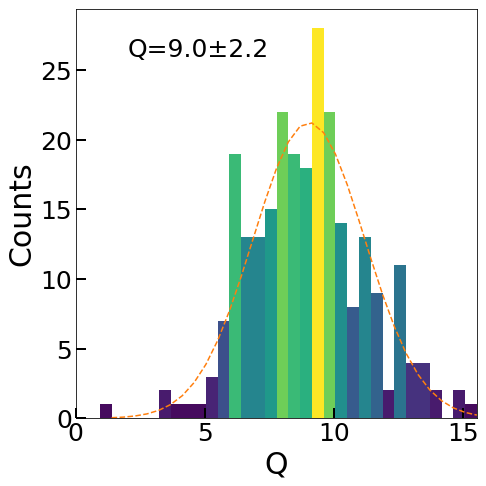

In [50]:
q_factors_on = np.array(q_factors_on)
fig,ax, n_on, bins_on = alexplot.default_hist(q_factors_on[q_factors_on < 18], colours=colours)
ax.set_xlabel("Q", fontsize=30)
ax.set_ylabel('Counts', fontsize=30)
ax.tick_params(labelsize=25, direction='in', size=10, width=2)
multi_gauss_a = GaussianModel(prefix='g' + str(0) + '_')
multi_gauss_fit_a = multi_gauss_a.fit(n_on, x=bins_on[1:])
ax.plot(bins_on[1:],multi_gauss_fit_a.best_fit, linestyle='--')
qcentre = np.round(multi_gauss_fit_a.best_values.get('g0_center'),1)
qsigma = np.round(multi_gauss_fit_a.best_values.get('g0_sigma'),1)
ax.text(2, 26,"Q="+str(qcentre)+ u'\u00b1'+str(qsigma), fontsize=25)
multi_gauss_fit_a.best_values
ax.set_xlim(0,)
plt.tight_layout(pad=1.6)
plt.savefig('C:\\Users\\alexc\\OneDrive - University of Cambridge\\Documents\\PhD Project\\Projects\\Boron Nitride spacer\\Trilayer hBN\\2019-03-07_051118_tri2_80nmNPs data analysis\\08_03_2019 80nm AuNPs on trilayer hBN Q-factor.jpg')

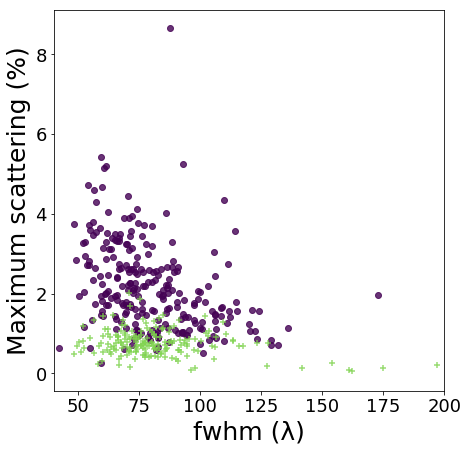

In [54]:
#combine all data into single set and see if kmeans can distinguish between sets of data

fig = plt.figure(1, figsize = (7,7))
ax = fig.add_subplot(111)
ax.scatter(fwhms_on, [i*100 for i in max_ints_on], color=colours[0], marker='o', alpha=0.8)
ax.scatter(fwhms_off, [i*100 for i in max_ints_off], color=colours[80], marker='+', alpha=0.8)
#ax.plot(xp,p(xp))
ax.set_xlabel(u"fwhm (\u03BB)", fontsize = 25)
ax.set_ylabel("Maximum scattering (%)", fontsize = 25)
ax.set_xlim(40,200)
ax.tick_params(labelsize=18)

In [55]:
max_ints_on = np.array(max_ints_on)
max_ints_off =  np.array(max_ints_off)
fwhms_on = np.array(fwhms_on)
fwhms_off = np.array(fwhms_off)

In [56]:
fwhms_on_cr = fwhms_on[fwhms_on < 140]
max_ints_on_cr = np.delete(max_ints_on, np.argwhere(fwhms_on > 140))
fwhms_on_cr = np.delete(fwhms_on_cr, np.argwhere(max_ints_on_cr > 0.06))
max_ints_on_cr = max_ints_on_cr[max_ints_on_cr < 0.06]
fwhms_on_cr = np.delete(fwhms_on_cr, np.argwhere(max_ints_on_cr < 0.007))
max_ints_on_cr = max_ints_on_cr[max_ints_on_cr > 0.007]

fwhms_off_cr = fwhms_off[fwhms_off < 140]
max_ints_off_cr = np.delete(max_ints_off, np.argwhere(fwhms_off > 140))

ln_ints_on = np.log(max_ints_on_cr*100)
ln_ints_off = np.log(max_ints_off_cr*100)

pfit_on = np.polyfit(fwhms_on_cr, ln_ints_on, deg=1)
pfit_off = np.polyfit(fwhms_off_cr, ln_ints_off, deg=1)
p_on = np.poly1d(pfit_on)
p_off = np.poly1d(pfit_off)
xp = np.linspace(40, 200, 100)

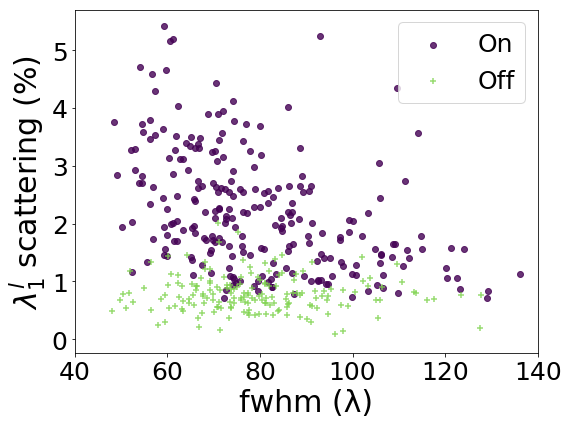

In [57]:
#combine all data into single set and see if kmeans can distinguish between sets of data

fig = plt.figure(1, figsize = (8,6))
ax = fig.add_subplot(111)
ax.scatter(fwhms_on_cr, [i*100 for i in max_ints_on_cr], color=colours[0], marker='o', alpha=0.8, label='On')
ax.scatter(fwhms_off_cr, [i*100 for i in max_ints_off_cr], color=colours[80], marker='+', alpha=0.8, label='Off')
ax.set_xlabel(u"fwhm (\u03BB)", fontsize = 30)
ax.set_ylabel("$\lambda_1^l$ scattering (%)", fontsize = 30)
ax.set_xlim(40,140)
ax.tick_params(labelsize=25)
ax.legend(fontsize=25)
plt.tight_layout()
plt.savefig('C:\\Users\\alexc\\OneDrive - University of Cambridge\\Documents\\PhD Project\\Projects\\Boron Nitride spacer\\Trilayer hBN\\2019-03-07_051118_tri2_80nmNPs data analysis\\08_03_2019 80nm AuNPs intensity vs fwhm.jpg')

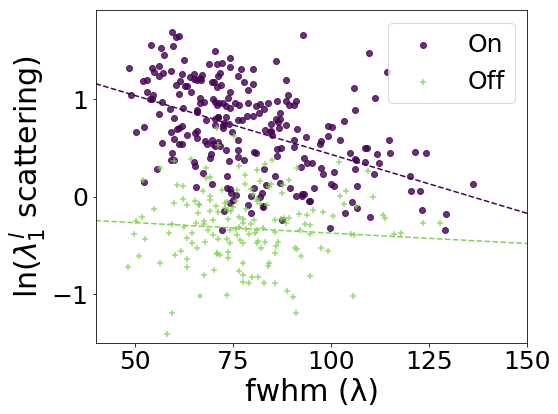

In [58]:
#combine all data into single set and see if kmeans can distinguish between sets of dat

fig = plt.figure(1, figsize = (8,6))
ax = fig.add_subplot(111)
ax.scatter(fwhms_on_cr, ln_ints_on, color=colours[0], marker='o', label='On', alpha=0.8)
ax.scatter(fwhms_off_cr, ln_ints_off, color=colours[80], marker='+', label='Off', alpha=0.8)
ax.plot(xp,p_on(xp), linestyle='--', color = colours[0])
ax.plot(xp,p_off(xp), linestyle='--', color = colours[80])

# plotting regression line from scikit learn
#plt.plot(X, y_predicted, color='r')

ax.set_xlabel(u"fwhm (\u03BB)", fontsize = 30)
ax.set_ylabel("ln($\lambda_1^l$ scattering)", fontsize = 30)
ax.set_xlim(40,150)
ax.set_ylim(-1.5,)
ax.tick_params(labelsize=25)
ax.legend(fontsize=25)
plt.tight_layout(pad=1.6)
plt.savefig('C:\\Users\\alexc\\OneDrive - University of Cambridge\\Documents\\PhD Project\\Projects\\Boron Nitride spacer\\Trilayer hBN\\2019-03-07_051118_tri2_80nmNPs data analysis\\08_03_2019 80nm AuNPs ln(intensity) vs fwhm.jpg')
## Could try to fit a polynomial to this of higher order 

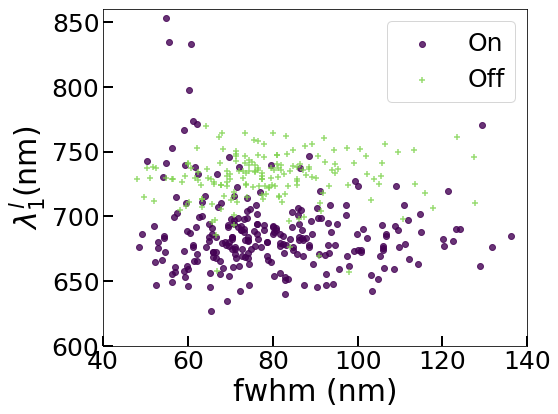

In [59]:
#combine all data into single set and see if kmeans can distinguish between sets of data

fig = plt.figure(1, figsize = (8,6))
ax = fig.add_subplot(111)
ax.scatter(fwhms_on, fit_l1_wls_on, color=colours[0], marker='o', alpha=0.8, label='On')
ax.scatter(fwhms_off, fit_l1_wls_off, color=colours[80], marker='+', alpha=0.8, label='Off')
ax.set_xlabel(u"fwhm (nm)", fontsize = 30)
ax.set_ylabel("$\lambda_1^l$(nm)", fontsize = 30)
ax.set_xlim(40,140)
ax.set_ylim(600, 860)
ax.tick_params(labelsize=25, direction='in', size=10, width=2)
ax.legend(fontsize=25)
plt.tight_layout(pad=1.6)
plt.savefig('C:\\Users\\alexc\\OneDrive - University of Cambridge\\Documents\\PhD Project\\Projects\\Boron Nitride spacer\\Trilayer hBN\\2019-03-07_051118_tri2_80nmNPs data analysis\\08_03_2019 80nm AuNPs wl_l1 vs fwhm.jpg')

('Slope:', array([[-0.01026122]]))
('Intercept:', array([1.49316365]))
('Root mean squared error: ', 0.17248334896209516)
('R2 score: ', 0.2129270505160088)


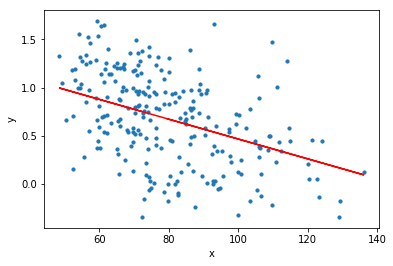

In [633]:
X = fwhms_on_cr.reshape(-1,1)
y = ln_ints_on.reshape(-1,1)

# Train using the test data, test_size=0.2 takes 20% of the data 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Model initialization
regression_model = LinearRegression()
# Fit the data(train the model)
regression_model.fit(X_train, y_train)
# Predict
y_predicted = regression_model.predict(X)

# model evaluation
rmse = mean_squared_error(y, y_predicted)
r2 = r2_score(y, y_predicted)

# printing values
print ('Slope:' ,regression_model.coef_)
print ('Intercept:', regression_model.intercept_)
print('Root mean squared error: ', rmse)
print('R2 score: ', r2)

# plotting values

# data points
plt.scatter(X, y, s=10)
plt.xlabel('x')
plt.ylabel('y')

# predicted values
plt.plot(X, y_predicted, color='r')
plt.show()